In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


In [56]:
# Global variables
EXTRACTOR_NAMES = ['DinoFeatureExtractor','DiftFeatureExtractor']
SCENE_NAMES = ['chair','drums','ficus','hotdog','lego','materials','mic','ship']
PATH = 'plot_data/global_cosine_similarity'

def load_cross_similarity(model_name):
    load_path = os.path.join("plot_data","cross_similarity")
    load_path = os.path.join(load_path,model_name)
    file = open(os.path.join(load_path,f"{model_name}.pkl"),'rb')
    cross_shape_similarity = pickle.load(file)
    cross_shape_similarity["Mean"] = np.mean(list(cross_shape_similarity.values()))
    return cross_shape_similarity

def load(model_name,scene_name_root):
    local_path = os.path.join(PATH,model_name)
    scene_name = scene_name_root
    if model_name == "DinoFeatureExtractor":
        scene_name = f"big/big_dino_{scene_name_root}_features"
    filename_camera = os.path.join(local_path,f"{scene_name}_camera.npy")
    filename_feat = os.path.join(local_path,f"{scene_name}_feat.npy")
    return np.load(filename_camera), np.load(filename_feat)


In [133]:
def plot(feat_differences_list,camera_differences_list, name_list,scene_index=None,axis_to_plot_in=plt,normalize_with_baseline=False,title = None):
    # Plot the results
    if axis_to_plot_in == plt:
        plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    if scene_index is None:
        scene_name = "Mean"
    else:
        scene_name = SCENE_NAMES[scene_index]
        
    number_of_experiments = len(feat_differences_list)
    color_list = ['blue','red']
    for exp_number in range(number_of_experiments):
        model_name = name_list[exp_number]
        # We do minus the cross similarity so that 0 represents "no similarity"
        if normalize_with_baseline:
            baseline = load_cross_similarity(model_name)[scene_name]
            
        else:
            baseline = 0
            axis_to_plot_in.axhline(y=load_cross_similarity(model_name)[scene_name], 
                    color=color_list[exp_number], 
                    linestyle='--',
                    label=f'cross shape sim for {model_name}')
            
        axis_to_plot_in.scatter(camera_differences_list[exp_number]*2 - 1,
                    feat_differences_list[exp_number] - baseline,
                    label=model_name,
                    alpha=0.7, edgecolors='black', marker='o',
                    color=color_list[exp_number])
        
    if title is None:
        title = f"{scene_name}".capitalize()
    else:
        title = title
    axis_to_plot_in.grid(True, linestyle='--', alpha=0.5)
    if axis_to_plot_in == plt:
        plt.xlabel("Camera Similarity", fontsize=12)
        plt.ylabel("Feature Similarity", fontsize=12)
        plt.ylim(0, 1)
        plt.title(title, fontsize=14)
        plt.tight_layout()  # Ensures the labels fit within the figure area
        plt.legend(loc='lower right', fontsize=10)
        plt.show()
    else:
        if scene_index == None or scene_index in [0,4]:
            axis_to_plot_in.set_ylabel("Feature Similarity", fontsize=12)
        if scene_index == None or scene_index >= 4:
            axis_to_plot_in.set_xlabel("Camera Similarity", fontsize=12)
        
        axis_to_plot_in.set_xlim(-1.1, 1.1)
        axis_to_plot_in.set_ylim(0, 1)
        axis_to_plot_in.set_title(title, fontsize=14)

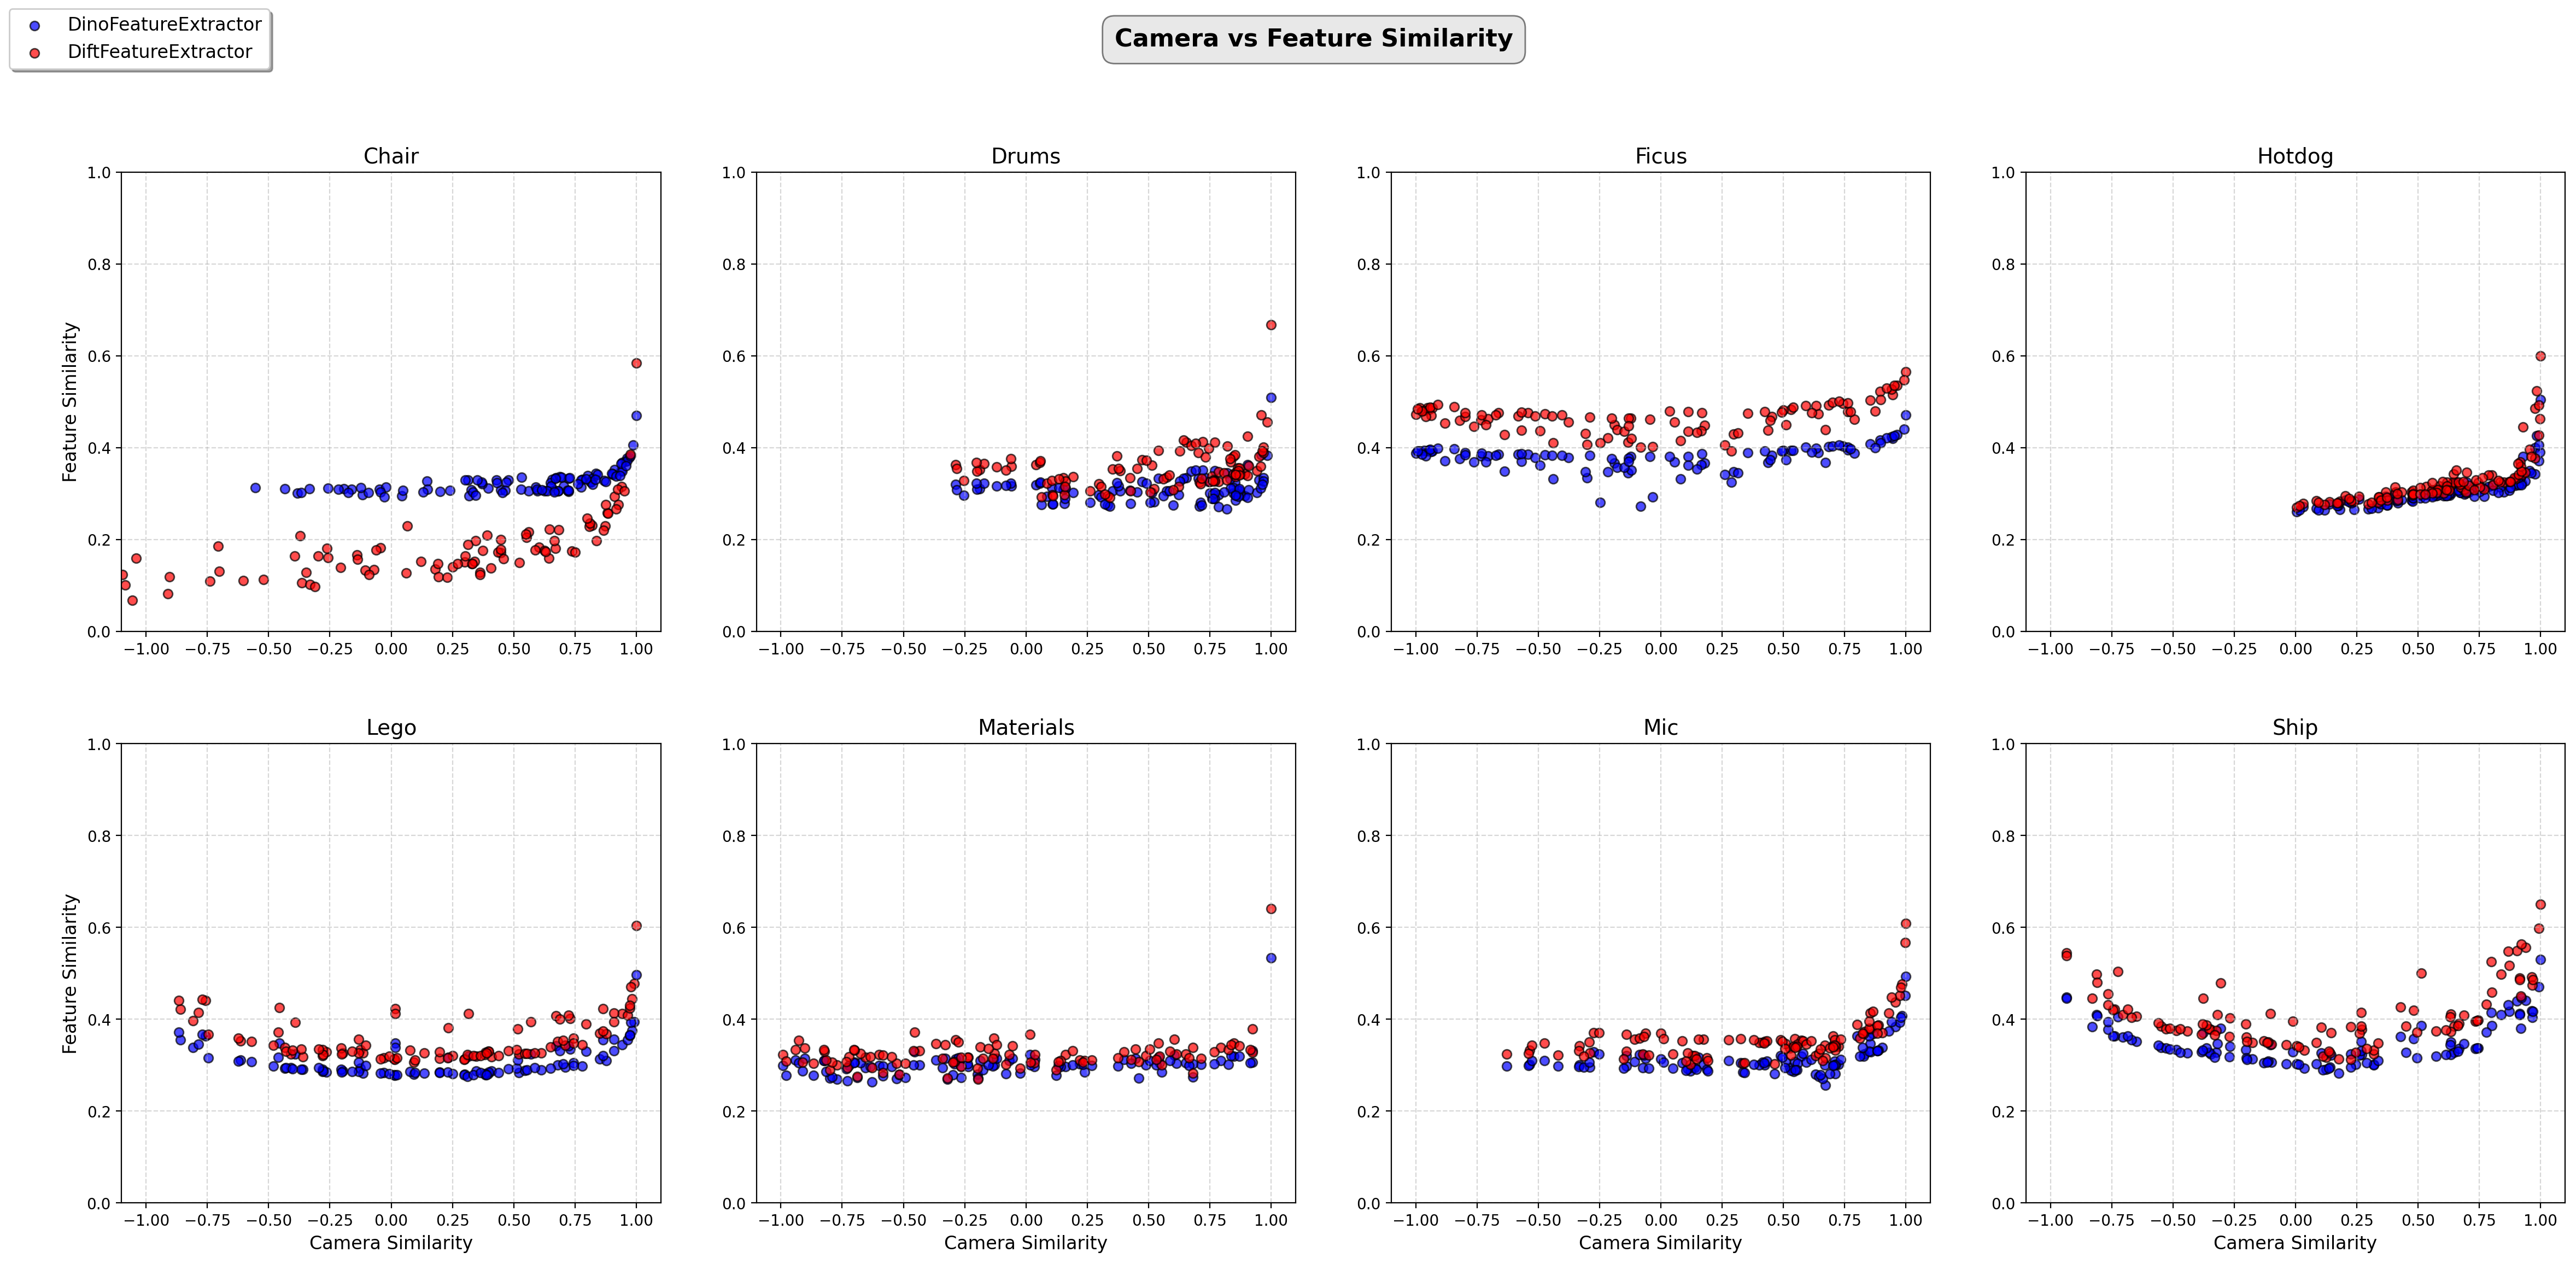

In [134]:
all_camera_differences_list = []
all_feat_differences_list = []
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 12),dpi=200)  # 4 rows, 2 columns
# Flatten the axs array for easy iteration
axs = axs.flatten()
    
for scene_name_root in SCENE_NAMES:
    feat_differences_list = []
    camera_differences_list = []
    name_list = []
    for model_name in EXTRACTOR_NAMES:
        camera, feat = load(model_name,scene_name_root)
        feat_differences_list.append(feat)
        camera_differences_list.append(camera)
        name_list.append(f"{model_name}")
    scene_index = SCENE_NAMES.index(scene_name_root)
    plot(feat_differences_list,camera_differences_list, name_list,scene_index,axs[scene_index],normalize_with_baseline=True)
    all_camera_differences_list.append(camera_differences_list)
    all_feat_differences_list.append(feat_differences_list)
handles, labels = axs[-1].get_legend_handles_labels()    
fig.legend(handles, labels, loc='upper left', fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.suptitle("Camera vs Feature Similarity",#\nwith respect to the Cross-Shape Similarity", 
             fontsize=16, fontweight='bold', 
             bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

# Remove labels from right and top axes
plt.tight_layout(pad=4.0)
plt.show()

In [135]:
c_array = np.array(all_camera_differences_list)
feat_array = np.array(all_feat_differences_list)

RESOLUTION = 100
c_array = c_array * RESOLUTION
c_array = c_array.astype(int)

# Iterate over unique X values
mean_feat = np.zeros((2,RESOLUTION))
for i in range(RESOLUTION):
    idx1 = c_array[:,0,:] == i
    if idx1.any():
        mean_feat[0,i] = np.mean(feat_array[:,0,:][idx1])
    idx2 = c_array[:,1,:] == i
    if idx2.any():
        mean_feat[1,i] = np.mean(feat_array[:,1,:][idx2])
    
camera_array = np.stack([np.arange(0,RESOLUTION,1)/RESOLUTION,
                         np.arange(0,RESOLUTION,1)/RESOLUTION,
                         np.arange(0,RESOLUTION,1)/RESOLUTION])

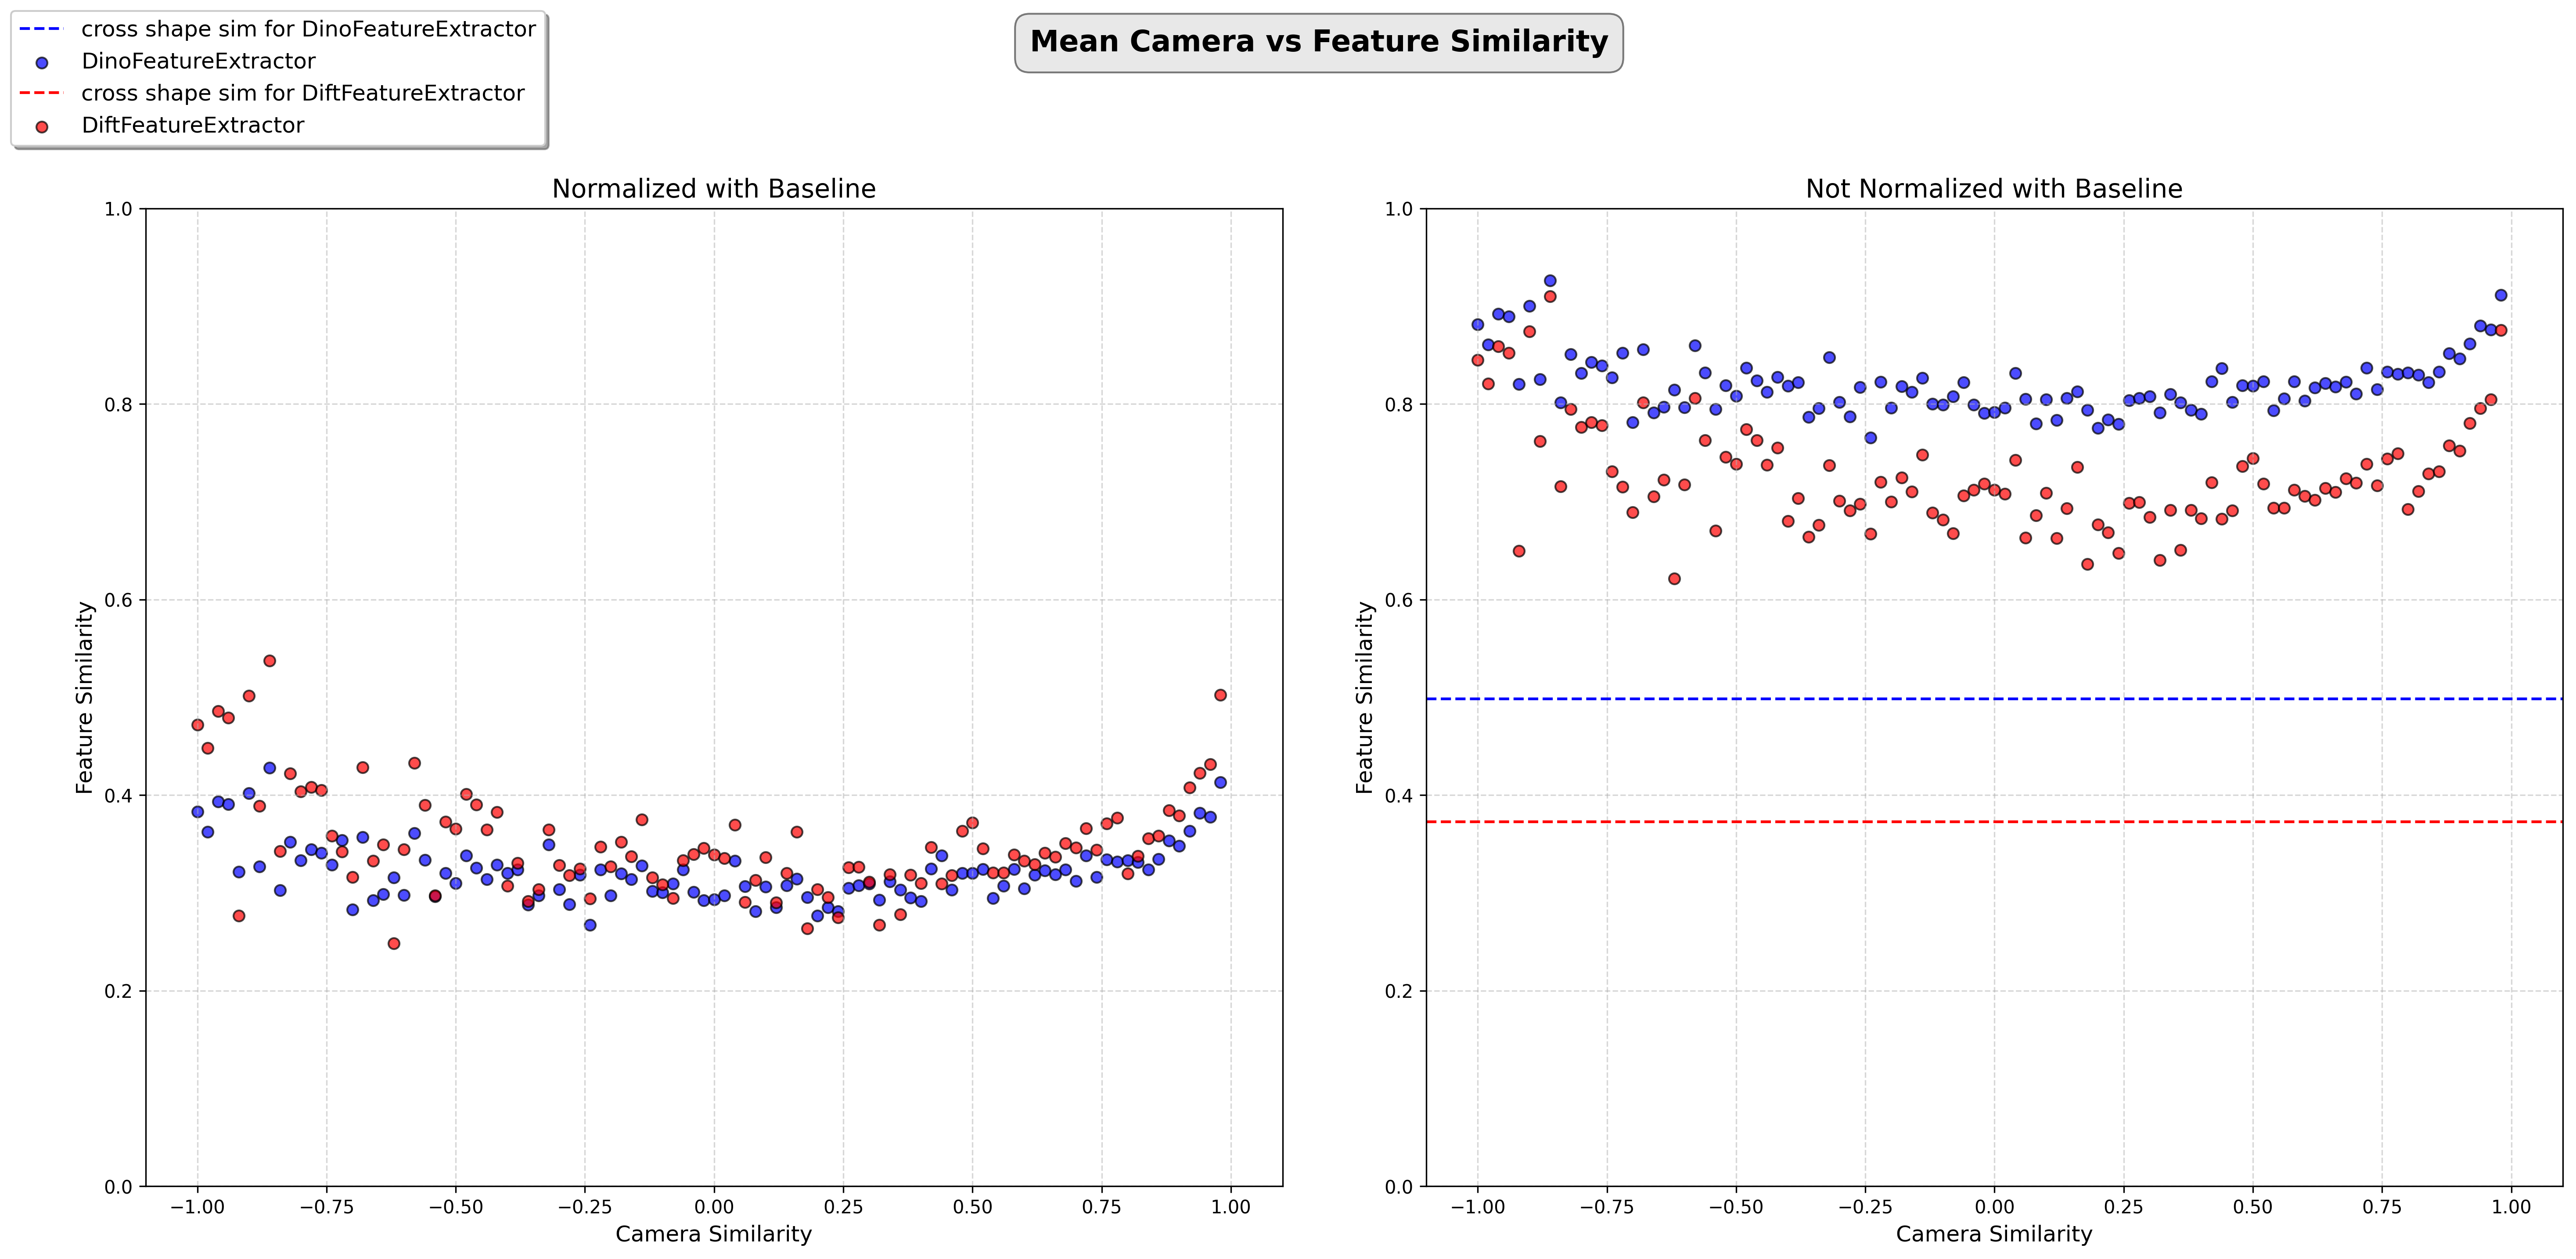

In [143]:
fig, axs = plt.subplots(1,2, figsize=(20, 10),dpi=300)  # 4 rows, 2 columns
# Flatten the axs array for easy iteration
axs = axs.flatten()

plot(mean_feat,camera_array,name_list,scene_index=None,axis_to_plot_in=axs[0],normalize_with_baseline=True, title="Normalized with Baseline")
plot(mean_feat,camera_array,name_list,scene_index=None,axis_to_plot_in=axs[1],normalize_with_baseline=False, title="Not Normalized with Baseline")

handles, labels = axs[-1].get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper left', fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.suptitle("Mean Camera vs Feature Similarity",
             fontsize=16, fontweight='bold', 
             bbox=dict(facecolor='lightgray', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))

# Remove labels from right and top axes
plt.tight_layout(pad=4.0)
plt.show()
